In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

import jax.random as random
import jax.numpy as jnp

from numpyro.infer import MCMC, NUTS, Predictive
import numpyro
import numpyro.distributions as dist
import arviz as az

from datetime import datetime, date, timedelta

from pycoingecko import CoinGeckoAPI

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

**Question**: How much variation in the FIL exchange rate can be explained by the Supply Ratio (locked+burned)/circulating supply vs wider Market trends or other factors?

**Approach**: Frame the question as a Bayesian inference experiment, with a strong prior on **no effect** for Supply Ratio. 

The FIL-USD exchange rate is modeled as a linear combination of factors that represent the wider market (BTC-USD) covariate, a (locked+burned)/circulating supply covariate, and some time-varying unexplained effects modelled as a random walk. If the Supply Ratio posterior is different from the null prior, this is considered support, generated by the data conditional on the structure of the model, that the exchange rate depends on the Suppy Ratio.

**Conclusion**: The wider Market covariate has about twice as strong an effect as the Supply Ratio. Both Market (BTC-USD) and Supply Ratio both have large and significant effects. 

**Limitations**: There are many plausible ways to set up this model, simple as it is. Different model choices and prior specifications can give different results. Without an obvious _a priori_-preferable specification --- for example, what the duration or scale of random walk innovations should be --- the simplest way to characterise the sensitivity of the conclusions is to iterate over many possible versions. This sensivity testing is done at the end.

### Prep data

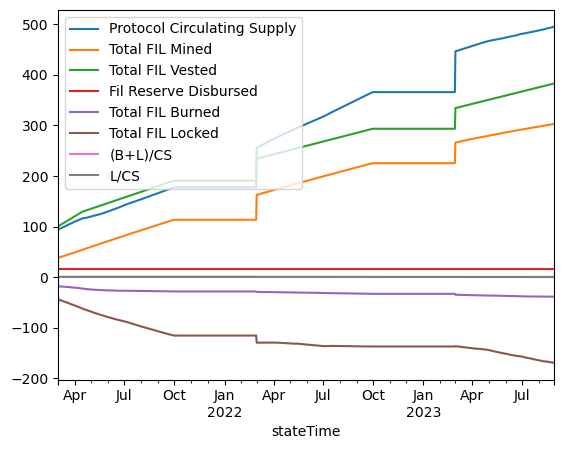

In [3]:
# downloaded from https://dashboard.starboard.ventures/dashboard
df = pd.read_csv('offline_info/FIL_Protocol_Circulating_Supply_new.csv')
df = df[df['stateTime'] >= '2021-01-01'] 
df.reset_index(inplace = True)
df['(B+L)/CS'] = -(df['Total FIL Burned'] + df['Total FIL Locked']) / df['Protocol Circulating Supply']
df['L/CS'] = -( df['Total FIL Locked']) / df['Protocol Circulating Supply']
df.drop('index',axis=1, inplace=True)
df['stateTime'] = pd.to_datetime(df['stateTime'])
df = df.set_index('stateTime').resample('D').interpolate(method='ffill')
df.plot();

In [4]:
# get exchange rate data
cg = CoinGeckoAPI()
def get_ts(id_='filecoin'):
    change_t = lambda x : datetime.utcfromtimestamp(x/1000).strftime('%Y-%m-%d')
    now = int(df.index[-1].timestamp())
    start_ago = int(df.index[0].timestamp())
    ts = cg.get_coin_market_chart_range_by_id(id=id_,
                                              vs_currency='usd',
                                              from_timestamp=start_ago,to_timestamp=now
                                             )
    ts_df = pd.DataFrame({"coin" : id_,
                          "time_s" : np.array(ts['prices']).T[0],
                      "time_d" : list(map(change_t, np.array(ts['prices']).T[0])),
                      "price" : np.array(ts['prices']).T[1],
                      "market_caps" : np.array(ts['market_caps']).T[1], 
                      "total_volumes" : np.array(ts['total_volumes']).T[1]})
    ts_df['time_d'] = pd.to_datetime(ts_df['time_d'])
    
    return ts_df

# get data, filter, and standardise
price_df_fil, price_df_btc, price_df_eth = get_ts('filecoin'), get_ts('bitcoin'), get_ts('ethereum')

price_df_fil = price_df_fil.pipe(lambda x: x[x['time_d'] <= df.index.max()])
price_df_fil = price_df_fil.pipe(lambda x: x[x['time_d'] >= df.index.min()])

price_df_eth = price_df_eth.pipe(lambda x: x[x['time_d'] <= df.index.max()])
price_df_eth = price_df_eth.pipe(lambda x: x[x['time_d'] >= df.index.min()])

price_df_btc = price_df_btc.pipe(lambda x: x[x['time_d'] <= df.index.max()])
price_df_btc = price_df_btc.pipe(lambda x: x[x['time_d'] >= df.index.min()])

price_df = pd.DataFrame({'date': price_df_fil['time_d'].values, 
                         'FIL' : price_df_fil['price'].values,
                        'BTC' : price_df_btc['price'].values,
                         'ETH' : price_df_eth['price'].values,})
price_df['(B+L)/CS'] = df['(B+L)/CS'].values
price_df['L/CS'] = df['L/CS'].values

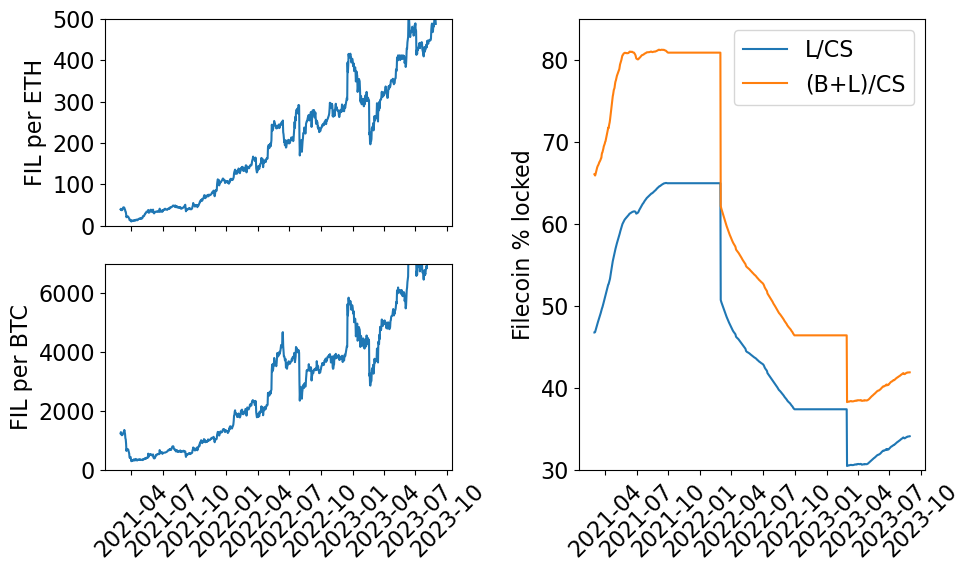

In [5]:
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['font.size'] = '16'

fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0, 0])
ax.plot(price_df.date, price_df['ETH'] / price_df['FIL'])
ax.set_ylabel("FIL per ETH")
ax.tick_params(labelbottom=False)
ax.set_ylim(0, 500)
ax.locator_params(axis='y', nbins=5)

ax = fig.add_subplot(gs[1, 0])
ax.plot(price_df.date, price_df['BTC'] / price_df['FIL'])
ax.set_ylabel("FIL per BTC")
ax.set_ylim(0, 7000)
ax.locator_params(axis='y', nbins=5)
ax.tick_params(axis='x', labelrotation = 45)

ax = fig.add_subplot(gs[:, 1])
ax.plot(price_df.date, 100 * price_df['L/CS'], label='L/CS')
ax.plot(price_df.date, 100 * price_df['(B+L)/CS'], label='(B+L)/CS')
ax.tick_params(axis='x', labelrotation = 45)
ax.set_ylabel("Filecoin % locked")
# axs[2].grid(True)
ax.set_ylim(30, 85)
ax.locator_params(axis='y', nbins=8)
ax.legend()
plt.show();

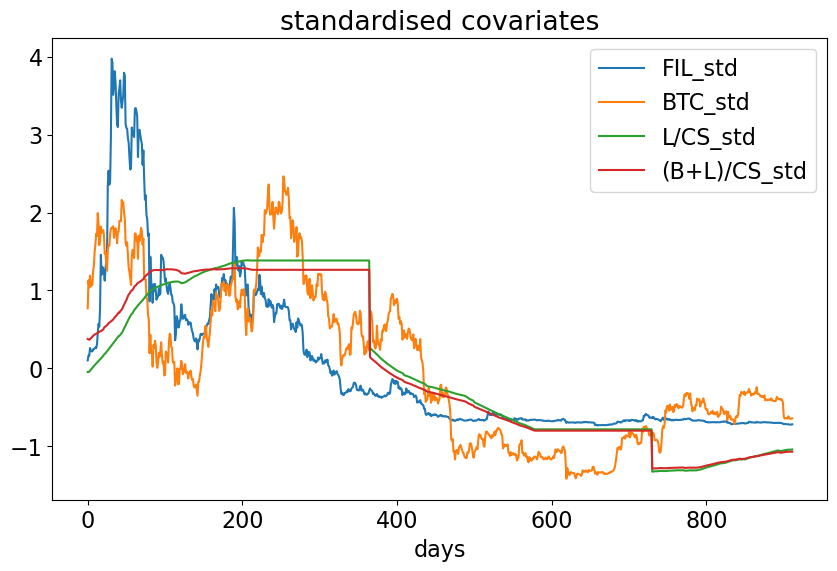

In [6]:
price_df[['FIL_std','BTC_std','ETH_std','L/CS_std','(B+L)/CS_std']] = price_df[['FIL',
                                                               'BTC',
                                                               'ETH',
                                                               'L/CS','(B+L)/CS']].pipe(lambda x: (x - x.mean())/x.std())
price_df[['FIL_std','BTC_std','L/CS_std','(B+L)/CS_std']].plot()
plt.xlabel("days")
plt.title("standardised covariates")
plt.show()

### Central Scenario

**Model**

Explain daily ($d$) variation in the FIL-USD exchange rate ($\text{FIL}_d$) with model:

$\text{FIL}_d = \beta^\text{Supply}  \text{Supply}_d +\beta^\text{Market}  \text{Market}_d + \text{RW}_d$

and priors:

$\beta^\text{Market} \sim N(0,10)$

$\beta^\text{Supply} \sim N(0,0.1)$

$\text{RW}_d \sim N(\text{RW}_{d-i}, \tau)$

$\tau \sim N(0,0.005)$

**Explanation**
* To model the Supply Ratio effect, (B+L)/CS is used as a covariate. It's given a prior that strongly favours no effect: $N(0,0.1)$. Deviation of $\beta^\text{Supply}$ from zero is interpreted as evidence for having an effect on the FIL-USD exchange rate, assuming the structure of the model is meaningful.
* To model the wider market BTC-USD exchange rate is used as a covariate. It is given an uninformative prior: $N(0,10)$ (a lower bar to observing an effect --- more easily informed by the data). 
* A random walk (RW) allows for unexplained variation beyond the scope of the above-mentioned covariates. The RW makes innovations every 30 days ($i=30$). 
* These assumptions can be sensitivity tested at the end. 

In [7]:
# Define model to explain variation in FIL
# in terms of BTC, burned_plus_locked and random variation

X_ = price_df.index.values
y_ = price_df.FIL_std

def model(y=None, 
          X=X_, 
          BTC=price_df['BTC_std'].values,
          burned_plus_locked=price_df['(B+L)/CS_std'].values,
          periodicity=14,
          n_forecast=None, 
          burned_plus_locked_counterfactual=None,
          y_sigma_scale=1,
          tau_scale=0.005,
          beta_btc_scale=0.1,
          beta_burned_plus_locked_scale=10,
         ):
    # likelihood scale prior
    y_sigma = numpyro.sample('y_sigma', dist.HalfNormal(scale=y_sigma_scale))
    # RW prior
    tau = numpyro.sample('tau', dist.HalfNormal(scale=tau_scale))
    # first coefficient of RW
    rw0 = numpyro.sample('rw0', dist.Normal(0,10))
    # btc coefficient prior
    beta_btc = numpyro.sample('beta_btc', dist.Normal(0,beta_btc_scale))
    # supply coefficient prior
    beta_burned_plus_locked = numpyro.sample('beta_(B+L)/CS', 
                                             dist.Normal(loc=0,scale=beta_burned_plus_locked_scale))
    # RW with periodicity day innovations
    nsteps = X.shape[0] // periodicity
    rw = numpyro.sample('rw_init', dist.GaussianRandomWalk(scale=tau, num_steps=nsteps))
    rw = numpyro.deterministic("rw", rw+rw0)
    rw = jnp.repeat(rw, periodicity)
    rw = jnp.append(rw, jnp.repeat(rw[-1], X.shape[0] % periodicity))
    mu = beta_btc * BTC + beta_burned_plus_locked * burned_plus_locked + rw
    
    # observational model
    numpyro.sample('obs', dist.Normal(loc=mu, scale=y_sigma), obs=y)
    
    # forecast future counterfactuals
    if n_forecast is not None:
        nsteps_f = n_forecast // periodicity
        rw_f = numpyro.sample('rw_init_f', dist.GaussianRandomWalk(scale=tau, num_steps=nsteps_f))
        rw_f = numpyro.deterministic("rw_f", rw_f + rw[-1])
        rw_f = jnp.repeat(rw_f, periodicity)
        rw_f = jnp.append(rw_f, jnp.repeat(rw_f[-1], n_forecast % periodicity))
        if burned_plus_locked_counterfactual is None:
            burned_plus_locked_counterfactual = burned_plus_locked[-1]
        mu_f = beta_btc * jnp.repeat(BTC[-1], n_forecast) + beta_burned_plus_locked * jnp.repeat(burned_plus_locked_counterfactual, n_forecast)+ rw_f
        numpyro.sample('y_pred', dist.Normal(loc=mu_f, scale=y_sigma), obs=None)

# fit model
INOVATION_RATE=30
NSTEPS=1000
mcmc = MCMC(
            NUTS(model), 
            num_warmup=NSTEPS, num_samples=NSTEPS)
mcmc.run(random.PRNGKey(0), y=jnp.array(y_), 
         X=jnp.array(X_), 
         BTC=jnp.array(price_df['BTC_std'].values),
         burned_plus_locked=jnp.array(price_df['(B+L)/CS_std'].values), 
         periodicity=INOVATION_RATE)
samples = mcmc.get_samples()

sample: 100%|█| 2000/2000 [00:02<00:00, 830.42it/s, 47 steps of size 7.22e-02. a


### Effect sizes

Check the effect sizes. Null result would be zero. 

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

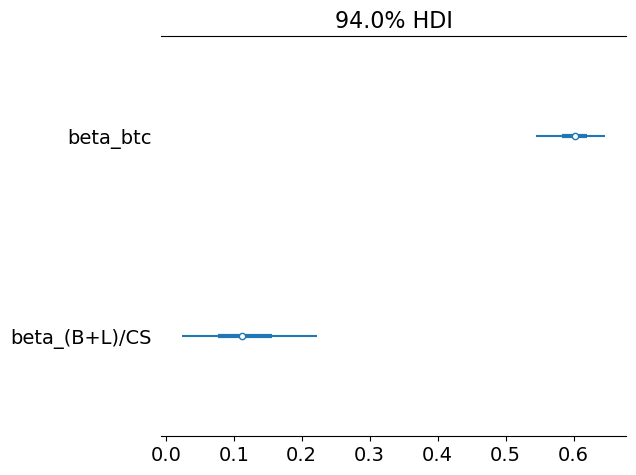

In [8]:

az.plot_forest(az.from_numpyro(mcmc),var_names=['beta_btc','beta_(B+L)/CS'])

### Predictions 
Check model predictions reproduce the data and look at counterfactual scenarios. 

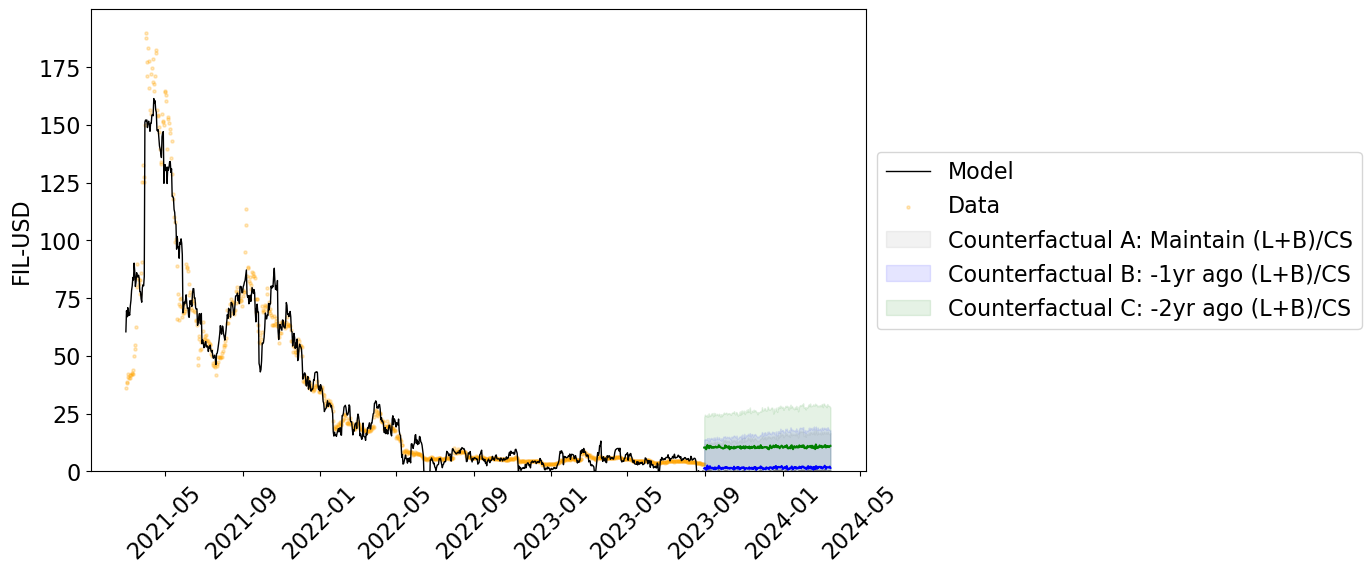

In [9]:
rng_key = random.PRNGKey(0)
predictive = Predictive(model, samples)
predictions = predictive(rng_key,X=X_, BTC=jnp.array(price_df['BTC_std'].values),
         burned_plus_locked=jnp.array(price_df['(B+L)/CS_std'].values),  
                         periodicity=INOVATION_RATE)["obs"]

# And consider future counterfactural scenarios with different levels of locking
future_predictions_counter0 = predictive(rng_key,X=X_, BTC=jnp.array(price_df['BTC_std'].values),
                              burned_plus_locked=jnp.array(price_df['(B+L)/CS_std'].values),  
                              periodicity=INOVATION_RATE,
                              n_forecast=200,
                              burned_plus_locked_counterfactual=None)["y_pred"]

future_predictions_counter1 = predictive(rng_key,X=X_, BTC=jnp.array(price_df['BTC_std'].values),
                              burned_plus_locked=jnp.array(price_df['(B+L)/CS_std'].values),  
                              periodicity=INOVATION_RATE,
                              n_forecast=200,
                              burned_plus_locked_counterfactual=jnp.array(price_df['(B+L)/CS_std'].values)[-365])["y_pred"]

future_predictions_counter2 = predictive(rng_key,X=X_, BTC=jnp.array(price_df['BTC_std'].values),
                              burned_plus_locked=jnp.array(price_df['(B+L)/CS_std'].values),  
                              periodicity=INOVATION_RATE,
                              n_forecast=200,
                              burned_plus_locked_counterfactual=jnp.array(price_df['(B+L)/CS_std'].values)[-int(365*2)])["y_pred"]


N_FORECAST = 200
X_pred_ = (X_ + N_FORECAST)[-N_FORECAST:]

def rescale(predictions):
    fil_std = price_df[['FIL']].std().values
    fil_mean = price_df[['FIL']].mean().values
    predictions_rs = predictions * fil_std + fil_mean
    
    return predictions_rs
    
predictions_rs = rescale(predictions)
future_predictions_counter0_rs = rescale(future_predictions_counter0)
future_predictions_counter1_rs = rescale(future_predictions_counter1)
future_predictions_counter2_rs = rescale(future_predictions_counter2)

dates_ = df.index
dates_pred_ = pd.date_range(start=df.index[-1]+timedelta(1), end=df.index[-1]+timedelta(N_FORECAST))

plt.plot(dates_, jnp.median(predictions_rs,axis=0),c='black',lw=1, label='Model')
plt.scatter(df.index, price_df[['FIL']], alpha=0.25,c='orange',s=5, label='Data')
plt.plot(dates_pred_, jnp.median(future_predictions_counter0_rs, axis=0), 
         c='grey')
plt.fill_between(dates_pred_, jnp.quantile(future_predictions_counter0_rs, 0.1, axis=0),
                 jnp.quantile(future_predictions_counter0_rs,0.9, axis=0), 
                 alpha=0.1, color='grey', label='Counterfactual A: Maintain (L+B)/CS')
plt.plot(dates_pred_, jnp.median(future_predictions_counter1_rs, axis=0), 
         color='blue')
plt.fill_between(dates_pred_, jnp.quantile(future_predictions_counter1_rs,0.1, axis=0),
                 jnp.quantile(future_predictions_counter1_rs,0.9, axis=0),
                 alpha=0.1, color='blue', label='Counterfactual B: -1yr ago (L+B)/CS')
plt.plot(dates_pred_, jnp.median(future_predictions_counter2_rs, axis=0), 
         color='green')
plt.fill_between(dates_pred_, jnp.quantile(future_predictions_counter2_rs,0.1, axis=0),
                 jnp.quantile(future_predictions_counter2_rs,0.9, axis=0),
                 alpha=0.1, color='green', label='Counterfactual C: -2yr ago (L+B)/CS')
plt.ylim(0,)
plt.xticks(rotation=45)
plt.ylabel("FIL-USD")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

The above counterfactual scenarios correspond to Supply Ratio levels at some earlier time (1 or 2yr ago). 

Now look at more counterfactual scenarios for specific levels of (B+L)/CS in {40,50,60} %:

In [10]:
forty_pct_index = np.argmin(np.abs(price_df['(B+L)/CS']-0.4))
fifty_pct_index = np.argmin(np.abs(price_df['(B+L)/CS']-0.5))
sixty_pct_index = np.argmin(np.abs(price_df['(B+L)/CS']-0.6))

# sanity check the model predictions are reproducing the data
rng_key = random.PRNGKey(0)
predictive = Predictive(model, samples)
predictions = predictive(rng_key,X=X_, BTC=jnp.array(price_df['BTC_std'].values),
         burned_plus_locked=jnp.array(price_df['(B+L)/CS_std'].values),  
                         periodicity=INOVATION_RATE)["obs"]

future_predictions_counterNow = predictive(rng_key,X=X_, BTC=jnp.array(price_df['BTC_std'].values),
                              burned_plus_locked=jnp.array(price_df['(B+L)/CS_std'].values),  
                              periodicity=INOVATION_RATE,
                              n_forecast=200,
                              burned_plus_locked_counterfactual=None)["y_pred"]

future_predictions_counter40 = predictive(rng_key,X=X_, BTC=jnp.array(price_df['BTC_std'].values),
                              burned_plus_locked=jnp.array(price_df['(B+L)/CS_std'].values),  
                              periodicity=INOVATION_RATE,
                              n_forecast=200,
                              burned_plus_locked_counterfactual=jnp.array(price_df['(B+L)/CS_std'].values)[-(df.index.shape[0] - forty_pct_index)])["y_pred"]

future_predictions_counter50 = predictive(rng_key,X=X_, BTC=jnp.array(price_df['BTC_std'].values),
                              burned_plus_locked=jnp.array(price_df['(B+L)/CS_std'].values),  
                              periodicity=INOVATION_RATE,
                              n_forecast=200,
                              burned_plus_locked_counterfactual=jnp.array(price_df['(B+L)/CS_std'].values)[-(df.index.shape[0] - fifty_pct_index)])["y_pred"]

future_predictions_counter60 = predictive(rng_key,X=X_, BTC=jnp.array(price_df['BTC_std'].values),
                              burned_plus_locked=jnp.array(price_df['(B+L)/CS_std'].values),  
                              periodicity=INOVATION_RATE,
                              n_forecast=200,
                              burned_plus_locked_counterfactual=jnp.array(price_df['(B+L)/CS_std'].values)[-(df.index.shape[0] - sixty_pct_index)])["y_pred"]

counterfactual_df = pd.DataFrame({"Quantile": ["FIL-USD Q25", "FIL-USD Q50", "FIL-USD Q75"],
    "(B+L)/CS=current" : 
              round(jnp.quantile(rescale(future_predictions_counterNow), jnp.array([0.25,0.5,0.75]), axis=0)[:,1]),
            "(B+L)/CS=40%" : 
              round(jnp.quantile(rescale(future_predictions_counter40), jnp.array([0.25,0.5,0.75]), axis=0)[:,1]),
              "(B+L)/CS=50%" : 
              round(jnp.quantile(rescale(future_predictions_counter50), jnp.array([0.25,0.5,0.75]), axis=0)[:,1]),
              "(B+L)/CS=60%" : 
              round(jnp.quantile(rescale(future_predictions_counter60), jnp.array([0.25,0.5,0.75]), axis=0)[:,1])
             })
counterfactual_df

,Quantile,(B+L)/CS=current,(B+L)/CS=40%,(B+L)/CS=50%,(B+L)/CS=60%
0,FIL-USD Q25,-7,-8,-5,-3
1,FIL-USD Q50,-1,-1,2,5
2,FIL-USD Q75,6,6,9,12


### L / CS as covariate
What happens if we alternatively use L / CS and not (L + B) / CS as the Supply Ratio covariate? Repeat above table for this:

In [11]:
forty_pct_index = np.argmin(np.abs(price_df['L/CS']-0.4))
fifty_pct_index = np.argmin(np.abs(price_df['L/CS']-0.5))
sixty_pct_index = np.argmin(np.abs(price_df['L/CS']-0.6))

# sanity check the model predictions are reproducing the data
rng_key = random.PRNGKey(0)
predictive = Predictive(model, samples)
predictions = predictive(rng_key,X=X_, BTC=jnp.array(price_df['BTC_std'].values),
         burned_plus_locked=jnp.array(price_df['L/CS_std'].values),  
                         periodicity=INOVATION_RATE)["obs"]

future_predictions_counterNow = predictive(rng_key,X=X_, BTC=jnp.array(price_df['BTC_std'].values),
                              burned_plus_locked=jnp.array(price_df['L/CS_std'].values),  
                              periodicity=INOVATION_RATE,
                              n_forecast=200,
                              burned_plus_locked_counterfactual=None)["y_pred"]

future_predictions_counter40 = predictive(rng_key,X=X_, BTC=jnp.array(price_df['BTC_std'].values),
                              burned_plus_locked=jnp.array(price_df['L/CS_std'].values),  
                              periodicity=INOVATION_RATE,
                              n_forecast=200,
                              burned_plus_locked_counterfactual=jnp.array(price_df['L/CS_std'].values)[-(df.index.shape[0] - forty_pct_index)])["y_pred"]

future_predictions_counter50 = predictive(rng_key,X=X_, BTC=jnp.array(price_df['BTC_std'].values),
                              burned_plus_locked=jnp.array(price_df['L/CS_std'].values),  
                              periodicity=INOVATION_RATE,
                              n_forecast=200,
                              burned_plus_locked_counterfactual=jnp.array(price_df['L/CS_std'].values)[-(df.index.shape[0] - fifty_pct_index)])["y_pred"]

future_predictions_counter60 = predictive(rng_key,X=X_, BTC=jnp.array(price_df['BTC_std'].values),
                              burned_plus_locked=jnp.array(price_df['L/CS_std'].values),  
                              periodicity=INOVATION_RATE,
                              n_forecast=200,
                              burned_plus_locked_counterfactual=jnp.array(price_df['L/CS_std'].values)[-(df.index.shape[0] - sixty_pct_index)])["y_pred"]

counterfactual_df_alternative = pd.DataFrame({"Quantile": ["FIL-USD Q25", "FIL-USD Q50", "FIL-USD Q75"],
    "L/CS=current" : 
              round(jnp.quantile(rescale(future_predictions_counterNow), jnp.array([0.25,0.5,0.75]), axis=0)[:,1]),
            "L/CS=40%" : 
              round(jnp.quantile(rescale(future_predictions_counter40), jnp.array([0.25,0.5,0.75]), axis=0)[:,1]),
              "L/CS=50%" : 
              round(jnp.quantile(rescale(future_predictions_counter50), jnp.array([0.25,0.5,0.75]), axis=0)[:,1]),
              "L/CS=60%" : 
              round(jnp.quantile(rescale(future_predictions_counter60), jnp.array([0.25,0.5,0.75]), axis=0)[:,1])
             })

In [12]:
counterfactual_df # (L+B) / CS

,Quantile,(B+L)/CS=current,(B+L)/CS=40%,(B+L)/CS=50%,(B+L)/CS=60%
0,FIL-USD Q25,-7,-8,-5,-3
1,FIL-USD Q50,-1,-1,2,5
2,FIL-USD Q75,6,6,9,12


In [13]:
counterfactual_df_alternative # L / CS

,Quantile,L/CS=current,L/CS=40%,L/CS=50%,L/CS=60%
0,FIL-USD Q25,-7,-5,-2,1
1,FIL-USD Q50,0,2,6,9
2,FIL-USD Q75,7,9,13,17


Similar trends as before.

### Sensitivity test model specific

Sensitivity model test prior assumptions.

In [14]:
innovation_rates = [10,30,60,90] # RW update lengths
tau_scales = [0.0025, 0.005, 0.01] # RW scale
y_sigma_scales = [0.5,1,2] # likelihood scale
beta_btc_scales = [0.1, 1, 10] # btc scale prior
beta_burned_plus_locked_scales = [0.1, 1,10] # locked supply scale prior

mcmc_s = MCMC(
            NUTS(model), 
            num_warmup=250, num_samples=250)

df_sensitivity = pd.DataFrame()

for innovation_rate_i, innovation_rate in enumerate(innovation_rates):
    for y_sigma_scale_i, y_sigma_scale in enumerate(y_sigma_scales):
        for tau_scale_i, tau_scale in enumerate(tau_scales):
            for beta_btc_scale_i, beta_btc_scale in enumerate(beta_btc_scales):
                for beta_burned_plus_locked_scale_i, beta_burned_plus_locked_scale in enumerate(beta_burned_plus_locked_scales):
                    mcmc_s.run(random.PRNGKey(0), y=jnp.array(y_), 
                             X=jnp.array(X_), 
                             BTC=jnp.array(price_df['BTC_std'].values),
                             burned_plus_locked=jnp.array(price_df['(B+L)/CS_std'].values), 
                             periodicity=innovation_rate,
                             y_sigma_scale=y_sigma_scale,
                             tau_scale=tau_scale,
                             beta_btc_scale=beta_btc_scale,
                             beta_burned_plus_locked_scale=beta_burned_plus_locked_scale,
                            )
                    
                    samples = mcmc_s.get_samples()
                    beta_supply_mean, beta_supply_std = samples['beta_(B+L)/CS'].mean(), samples['beta_(B+L)/CS'].std()
                    beta_btc_mean, beta_btc_std = samples['beta_btc'].mean(), samples['beta_btc'].std()
                    
                    df_sensitivity_i = pd.DataFrame()
                    df_sensitivity_i['Scenario'] = [f'{innovation_rate=} {y_sigma_scale=} {tau_scale=} {beta_btc_scale=} {beta_burned_plus_locked_scale=}']
                    print(f'{innovation_rate=} {y_sigma_scale=} {tau_scale=} {beta_btc_scale=} {beta_burned_plus_locked_scale=}')

                    df_sensitivity_i['beta_(B+L)/CS_mean'] = [beta_supply_mean]
                    df_sensitivity_i['beta_(B+L)/CS_std'] = [beta_supply_std]

                    df_sensitivity_i['beta_btc_mean'] = [beta_btc_mean]
                    df_sensitivity_i['beta_btc_std'] = [beta_btc_std]

                    df_sensitivity = df_sensitivity.append(df_sensitivity_i)

sample: 100%|█| 500/500 [00:01<00:00, 267.57it/s, 31 steps of size 6.78e-02. acc


innovation_rate=10 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 251.51it/s, 31 steps of size 9.50e-02. acc


innovation_rate=10 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 273.25it/s, 31 steps of size 9.31e-02. acc


innovation_rate=10 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 262.93it/s, 31 steps of size 8.38e-02. acc


innovation_rate=10 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 258.86it/s, 31 steps of size 2.39e-02. acc


innovation_rate=10 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 270.96it/s, 31 steps of size 7.68e-02. acc


innovation_rate=10 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 279.73it/s, 31 steps of size 4.74e-02. acc


innovation_rate=10 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 281.73it/s, 31 steps of size 6.58e-02. acc


innovation_rate=10 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 274.02it/s, 31 steps of size 5.20e-02. acc


innovation_rate=10 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 267.21it/s, 31 steps of size 5.44e-02. acc


innovation_rate=10 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 277.47it/s, 31 steps of size 4.30e-02. acc


innovation_rate=10 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 271.01it/s, 31 steps of size 2.46e-02. acc


innovation_rate=10 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 259.50it/s, 31 steps of size 9.42e-02. acc


innovation_rate=10 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 245.00it/s, 191 steps of size 5.12e-02. ac


innovation_rate=10 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:02<00:00, 245.84it/s, 63 steps of size 5.38e-02. acc


innovation_rate=10 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 271.38it/s, 31 steps of size 7.48e-02. acc


innovation_rate=10 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 281.16it/s, 31 steps of size 5.50e-02. acc


innovation_rate=10 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 263.60it/s, 31 steps of size 4.32e-02. acc


innovation_rate=10 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 227.06it/s, 63 steps of size 2.14e-02. acc


innovation_rate=10 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 259.72it/s, 31 steps of size 8.39e-02. acc


innovation_rate=10 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:02<00:00, 249.58it/s, 31 steps of size 3.89e-02. acc


innovation_rate=10 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 255.02it/s, 31 steps of size 6.13e-02. acc


innovation_rate=10 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 268.25it/s, 31 steps of size 7.55e-02. acc


innovation_rate=10 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:02<00:00, 232.80it/s, 63 steps of size 2.32e-02. acc


innovation_rate=10 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 258.96it/s, 63 steps of size 6.10e-02. acc


innovation_rate=10 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 267.30it/s, 63 steps of size 5.17e-02. acc


innovation_rate=10 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 269.09it/s, 63 steps of size 6.92e-02. acc


innovation_rate=10 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 256.59it/s, 191 steps of size 4.72e-02. ac


innovation_rate=10 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 280.49it/s, 31 steps of size 6.39e-02. acc


innovation_rate=10 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 251.62it/s, 31 steps of size 3.54e-02. acc


innovation_rate=10 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 272.52it/s, 31 steps of size 6.60e-02. acc


innovation_rate=10 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 257.73it/s, 31 steps of size 1.24e-01. acc


innovation_rate=10 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 266.39it/s, 31 steps of size 6.44e-02. acc


innovation_rate=10 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 270.79it/s, 31 steps of size 9.79e-02. acc


innovation_rate=10 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 265.23it/s, 31 steps of size 5.71e-02. acc


innovation_rate=10 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:02<00:00, 247.66it/s, 31 steps of size 1.01e-01. acc


innovation_rate=10 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 264.12it/s, 31 steps of size 7.03e-02. acc


innovation_rate=10 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 265.61it/s, 31 steps of size 5.30e-02. acc


innovation_rate=10 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 255.17it/s, 63 steps of size 4.98e-02. acc


innovation_rate=10 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 267.28it/s, 31 steps of size 6.32e-02. acc


innovation_rate=10 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 215.38it/s, 31 steps of size 5.91e-02. acc


innovation_rate=10 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:02<00:00, 207.14it/s, 415 steps of size 4.34e-02. ac


innovation_rate=10 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 247.51it/s, 31 steps of size 7.96e-02. acc


innovation_rate=10 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 264.13it/s, 31 steps of size 6.16e-02. acc


innovation_rate=10 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 263.56it/s, 31 steps of size 7.17e-02. acc


innovation_rate=10 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 256.74it/s, 63 steps of size 6.27e-02. acc


innovation_rate=10 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 246.76it/s, 31 steps of size 1.16e-01. acc


innovation_rate=10 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 274.55it/s, 31 steps of size 7.31e-02. acc


innovation_rate=10 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 203.50it/s, 63 steps of size 5.23e-02. acc


innovation_rate=10 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 257.28it/s, 63 steps of size 3.93e-02. acc


innovation_rate=10 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 253.63it/s, 31 steps of size 5.47e-02. acc


innovation_rate=10 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 251.76it/s, 31 steps of size 5.58e-02. acc


innovation_rate=10 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 248.97it/s, 63 steps of size 4.68e-02. acc


innovation_rate=10 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 270.01it/s, 31 steps of size 1.83e-02. acc


innovation_rate=10 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 260.86it/s, 415 steps of size 6.62e-02. ac


innovation_rate=10 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 236.77it/s, 31 steps of size 6.01e-02. acc


innovation_rate=10 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 263.28it/s, 191 steps of size 6.11e-02. ac


innovation_rate=10 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 270.68it/s, 31 steps of size 9.30e-02. acc


innovation_rate=10 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 269.18it/s, 31 steps of size 3.41e-02. acc


innovation_rate=10 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 273.20it/s, 31 steps of size 2.99e-02. acc


innovation_rate=10 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 252.83it/s, 31 steps of size 1.21e-01. acc


innovation_rate=10 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 250.70it/s, 31 steps of size 9.71e-02. acc


innovation_rate=10 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:02<00:00, 228.36it/s, 31 steps of size 4.18e-02. acc


innovation_rate=10 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 268.80it/s, 31 steps of size 5.73e-02. acc


innovation_rate=10 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 261.23it/s, 31 steps of size 8.08e-02. acc


innovation_rate=10 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 258.14it/s, 31 steps of size 8.26e-02. acc


innovation_rate=10 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 275.87it/s, 31 steps of size 2.84e-02. acc


innovation_rate=10 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 256.13it/s, 31 steps of size 1.07e-01. acc


innovation_rate=10 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 263.95it/s, 31 steps of size 6.71e-02. acc


innovation_rate=10 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 273.49it/s, 31 steps of size 6.39e-02. acc


innovation_rate=10 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 237.72it/s, 63 steps of size 6.72e-02. acc


innovation_rate=10 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 262.37it/s, 31 steps of size 7.72e-02. acc


innovation_rate=10 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 263.08it/s, 31 steps of size 4.66e-02. acc


innovation_rate=10 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 265.91it/s, 31 steps of size 4.27e-02. acc


innovation_rate=10 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 263.35it/s, 31 steps of size 1.02e-01. acc


innovation_rate=10 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 262.10it/s, 31 steps of size 4.87e-02. acc


innovation_rate=10 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 261.06it/s, 31 steps of size 9.80e-02. acc


innovation_rate=10 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:02<00:00, 226.58it/s, 31 steps of size 9.06e-02. acc


innovation_rate=10 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 226.90it/s, 31 steps of size 6.88e-02. acc


innovation_rate=10 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 227.09it/s, 31 steps of size 4.37e-02. acc


innovation_rate=10 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:02<00:00, 238.63it/s, 31 steps of size 8.02e-02. acc


innovation_rate=10 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 247.62it/s, 15 steps of size 1.25e-01. acc


innovation_rate=30 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 253.64it/s, 79 steps of size 1.12e-01. acc


innovation_rate=30 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 258.50it/s, 31 steps of size 8.55e-02. acc


innovation_rate=30 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 254.13it/s, 47 steps of size 1.02e-01. acc


innovation_rate=30 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 249.87it/s, 47 steps of size 1.17e-01. acc


innovation_rate=30 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 257.67it/s, 63 steps of size 1.21e-01. acc


innovation_rate=30 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 231.03it/s, 31 steps of size 9.56e-02. acc


innovation_rate=30 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 265.75it/s, 47 steps of size 1.23e-01. acc


innovation_rate=30 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 254.68it/s, 7 steps of size 1.34e-01. acc.


innovation_rate=30 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 246.96it/s, 31 steps of size 5.44e-02. acc


innovation_rate=30 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 251.37it/s, 31 steps of size 6.27e-02. acc


innovation_rate=30 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 253.07it/s, 63 steps of size 5.76e-02. acc


innovation_rate=30 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 261.95it/s, 47 steps of size 5.94e-02. acc


innovation_rate=30 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 261.47it/s, 31 steps of size 7.07e-02. acc


innovation_rate=30 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:02<00:00, 245.58it/s, 15 steps of size 8.09e-02. acc


innovation_rate=30 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 222.58it/s, 31 steps of size 6.89e-02. acc


innovation_rate=30 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 221.51it/s, 31 steps of size 6.92e-02. acc


innovation_rate=30 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:02<00:00, 247.35it/s, 63 steps of size 5.89e-02. acc


innovation_rate=30 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 209.90it/s, 111 steps of size 5.04e-02. ac


innovation_rate=30 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 249.72it/s, 63 steps of size 2.56e-02. acc


innovation_rate=30 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:02<00:00, 221.66it/s, 63 steps of size 3.60e-02. acc


innovation_rate=30 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 233.78it/s, 127 steps of size 4.34e-02. ac


innovation_rate=30 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 199.47it/s, 31 steps of size 3.24e-02. acc


innovation_rate=30 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:02<00:00, 238.04it/s, 127 steps of size 3.83e-02. ac


innovation_rate=30 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 245.77it/s, 79 steps of size 4.36e-02. acc


innovation_rate=30 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 245.19it/s, 63 steps of size 3.43e-02. acc


innovation_rate=30 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:02<00:00, 236.83it/s, 63 steps of size 5.07e-02. acc


innovation_rate=30 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 268.50it/s, 31 steps of size 1.16e-01. acc


innovation_rate=30 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 271.70it/s, 7 steps of size 1.18e-01. acc.


innovation_rate=30 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 274.75it/s, 31 steps of size 1.32e-01. acc


innovation_rate=30 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 265.80it/s, 63 steps of size 1.19e-01. acc


innovation_rate=30 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 263.53it/s, 15 steps of size 1.18e-01. acc


innovation_rate=30 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 252.35it/s, 31 steps of size 1.07e-01. acc


innovation_rate=30 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 262.38it/s, 63 steps of size 9.25e-02. acc


innovation_rate=30 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 259.14it/s, 15 steps of size 1.38e-01. acc


innovation_rate=30 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:02<00:00, 225.40it/s, 31 steps of size 9.03e-02. acc


innovation_rate=30 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 258.19it/s, 31 steps of size 5.51e-02. acc


innovation_rate=30 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 268.23it/s, 31 steps of size 6.38e-02. acc


innovation_rate=30 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 261.99it/s, 15 steps of size 1.01e-01. acc


innovation_rate=30 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 252.78it/s, 95 steps of size 4.43e-02. acc


innovation_rate=30 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 256.82it/s, 127 steps of size 5.05e-02. ac


innovation_rate=30 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 250.41it/s, 31 steps of size 5.71e-02. acc


innovation_rate=30 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 269.43it/s, 31 steps of size 7.75e-02. acc


innovation_rate=30 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 241.28it/s, 63 steps of size 6.15e-02. acc


innovation_rate=30 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 250.91it/s, 63 steps of size 5.82e-02. acc


innovation_rate=30 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 225.08it/s, 31 steps of size 5.40e-02. acc


innovation_rate=30 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 254.33it/s, 31 steps of size 5.16e-02. acc


innovation_rate=30 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:02<00:00, 248.26it/s, 159 steps of size 6.25e-02. ac


innovation_rate=30 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 234.27it/s, 31 steps of size 4.50e-02. acc


innovation_rate=30 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 243.00it/s, 63 steps of size 4.50e-02. acc


innovation_rate=30 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:02<00:00, 214.40it/s, 191 steps of size 3.28e-02. ac


innovation_rate=30 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 240.67it/s, 95 steps of size 3.51e-02. acc


innovation_rate=30 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 254.35it/s, 79 steps of size 5.27e-02. acc


innovation_rate=30 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:02<00:00, 239.74it/s, 31 steps of size 3.82e-02. acc


innovation_rate=30 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 245.86it/s, 31 steps of size 1.08e-01. acc


innovation_rate=30 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 241.82it/s, 7 steps of size 1.19e-01. acc.


innovation_rate=30 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:02<00:00, 211.22it/s, 47 steps of size 1.54e-01. acc


innovation_rate=30 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 248.02it/s, 63 steps of size 1.42e-01. acc


innovation_rate=30 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 247.88it/s, 7 steps of size 1.79e-01. acc.


innovation_rate=30 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 256.83it/s, 47 steps of size 1.05e-01. acc


innovation_rate=30 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 255.68it/s, 63 steps of size 7.61e-02. acc


innovation_rate=30 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 245.68it/s, 127 steps of size 1.28e-01. ac


innovation_rate=30 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 264.86it/s, 47 steps of size 1.24e-01. acc


innovation_rate=30 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 257.32it/s, 47 steps of size 6.75e-02. acc


innovation_rate=30 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 262.86it/s, 31 steps of size 5.52e-02. acc


innovation_rate=30 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 257.46it/s, 63 steps of size 4.61e-02. acc


innovation_rate=30 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 257.65it/s, 31 steps of size 6.44e-02. acc


innovation_rate=30 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 244.77it/s, 63 steps of size 4.17e-02. acc


innovation_rate=30 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:02<00:00, 212.25it/s, 31 steps of size 6.51e-02. acc


innovation_rate=30 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 239.31it/s, 95 steps of size 4.93e-02. acc


innovation_rate=30 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 242.08it/s, 15 steps of size 9.08e-02. acc


innovation_rate=30 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:02<00:00, 234.30it/s, 63 steps of size 5.41e-02. acc


innovation_rate=30 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 239.03it/s, 127 steps of size 3.22e-02. ac


innovation_rate=30 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 244.86it/s, 63 steps of size 3.49e-02. acc


innovation_rate=30 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:02<00:00, 245.89it/s, 95 steps of size 3.53e-02. acc


innovation_rate=30 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 244.57it/s, 63 steps of size 7.62e-02. acc


innovation_rate=30 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 241.30it/s, 63 steps of size 3.77e-02. acc


innovation_rate=30 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:02<00:00, 216.37it/s, 79 steps of size 5.12e-02. acc


innovation_rate=30 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 237.96it/s, 127 steps of size 4.30e-02. ac


innovation_rate=30 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 240.95it/s, 111 steps of size 2.82e-02. ac


innovation_rate=30 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:02<00:00, 208.06it/s, 95 steps of size 3.58e-02. acc


innovation_rate=30 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 285.52it/s, 7 steps of size 2.11e-01. acc.


innovation_rate=60 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 283.84it/s, 31 steps of size 1.69e-01. acc


innovation_rate=60 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 284.87it/s, 39 steps of size 1.61e-01. acc


innovation_rate=60 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 286.69it/s, 31 steps of size 1.71e-01. acc


innovation_rate=60 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 263.21it/s, 39 steps of size 1.57e-01. acc


innovation_rate=60 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 255.33it/s, 71 steps of size 1.65e-01. acc


innovation_rate=60 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 274.42it/s, 23 steps of size 1.40e-01. acc


innovation_rate=60 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 278.04it/s, 15 steps of size 1.62e-01. acc


innovation_rate=60 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 283.20it/s, 15 steps of size 1.83e-01. acc


innovation_rate=60 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 261.63it/s, 15 steps of size 1.62e-01. acc


innovation_rate=60 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 281.87it/s, 15 steps of size 1.44e-01. acc


innovation_rate=60 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 272.62it/s, 15 steps of size 1.40e-01. acc


innovation_rate=60 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 231.03it/s, 31 steps of size 1.39e-01. acc


innovation_rate=60 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 284.19it/s, 15 steps of size 1.56e-01. acc


innovation_rate=60 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 281.03it/s, 31 steps of size 1.41e-01. acc


innovation_rate=60 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 271.61it/s, 15 steps of size 1.52e-01. acc


innovation_rate=60 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 273.32it/s, 15 steps of size 1.24e-01. acc


innovation_rate=60 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 261.26it/s, 47 steps of size 1.17e-01. acc


innovation_rate=60 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 264.53it/s, 15 steps of size 1.34e-01. acc


innovation_rate=60 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 268.74it/s, 31 steps of size 9.76e-02. acc


innovation_rate=60 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 262.70it/s, 31 steps of size 1.30e-01. acc


innovation_rate=60 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 257.50it/s, 15 steps of size 8.55e-02. acc


innovation_rate=60 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 261.97it/s, 15 steps of size 8.58e-02. acc


innovation_rate=60 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 264.85it/s, 15 steps of size 8.48e-02. acc


innovation_rate=60 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 271.37it/s, 15 steps of size 1.08e-01. acc


innovation_rate=60 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 183.88it/s, 15 steps of size 1.04e-01. acc


innovation_rate=60 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 269.93it/s, 15 steps of size 1.28e-01. acc


innovation_rate=60 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 279.40it/s, 63 steps of size 1.60e-01. acc


innovation_rate=60 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 279.50it/s, 47 steps of size 1.40e-01. acc


innovation_rate=60 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 281.23it/s, 15 steps of size 1.60e-01. acc


innovation_rate=60 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 257.42it/s, 47 steps of size 1.25e-01. acc


innovation_rate=60 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 266.59it/s, 39 steps of size 1.52e-01. acc


innovation_rate=60 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 263.53it/s, 47 steps of size 1.43e-01. acc


innovation_rate=60 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 273.46it/s, 63 steps of size 1.57e-01. acc


innovation_rate=60 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 260.96it/s, 39 steps of size 1.25e-01. acc


innovation_rate=60 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 274.23it/s, 31 steps of size 1.65e-01. acc


innovation_rate=60 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 264.11it/s, 39 steps of size 1.52e-01. acc


innovation_rate=60 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 277.14it/s, 15 steps of size 1.14e-01. acc


innovation_rate=60 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 250.30it/s, 63 steps of size 1.71e-01. acc


innovation_rate=60 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 199.18it/s, 15 steps of size 1.38e-01. acc


innovation_rate=60 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 255.71it/s, 15 steps of size 1.19e-01. acc


innovation_rate=60 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 264.58it/s, 15 steps of size 1.42e-01. acc


innovation_rate=60 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 258.17it/s, 15 steps of size 1.34e-01. acc


innovation_rate=60 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 260.74it/s, 31 steps of size 1.30e-01. acc


innovation_rate=60 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 257.18it/s, 15 steps of size 1.70e-01. acc


innovation_rate=60 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 217.79it/s, 15 steps of size 9.72e-02. acc


innovation_rate=60 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 243.30it/s, 31 steps of size 9.27e-02. acc


innovation_rate=60 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 264.79it/s, 15 steps of size 1.11e-01. acc


innovation_rate=60 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 261.00it/s, 15 steps of size 9.09e-02. acc


innovation_rate=60 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 263.10it/s, 15 steps of size 1.16e-01. acc


innovation_rate=60 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 269.91it/s, 15 steps of size 9.43e-02. acc


innovation_rate=60 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 249.16it/s, 31 steps of size 1.09e-01. acc


innovation_rate=60 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 254.43it/s, 15 steps of size 1.08e-01. acc


innovation_rate=60 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 254.81it/s, 31 steps of size 1.60e-01. acc


innovation_rate=60 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 196.97it/s, 23 steps of size 1.52e-01. acc


innovation_rate=60 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 281.41it/s, 31 steps of size 1.90e-01. acc


innovation_rate=60 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 269.31it/s, 39 steps of size 1.66e-01. acc


innovation_rate=60 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 261.09it/s, 15 steps of size 1.91e-01. acc


innovation_rate=60 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 281.04it/s, 7 steps of size 1.93e-01. acc.


innovation_rate=60 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 260.64it/s, 63 steps of size 1.63e-01. acc


innovation_rate=60 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 256.83it/s, 31 steps of size 1.40e-01. acc


innovation_rate=60 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 250.81it/s, 63 steps of size 1.59e-01. acc


innovation_rate=60 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 270.19it/s, 55 steps of size 1.55e-01. acc


innovation_rate=60 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 263.99it/s, 15 steps of size 1.38e-01. acc


innovation_rate=60 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 280.49it/s, 31 steps of size 1.45e-01. acc


innovation_rate=60 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 273.70it/s, 15 steps of size 1.10e-01. acc


innovation_rate=60 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 285.12it/s, 31 steps of size 1.45e-01. acc


innovation_rate=60 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 279.62it/s, 31 steps of size 1.52e-01. acc


innovation_rate=60 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 282.19it/s, 15 steps of size 1.33e-01. acc


innovation_rate=60 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 219.40it/s, 15 steps of size 1.60e-01. acc


innovation_rate=60 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 235.45it/s, 15 steps of size 1.71e-01. acc


innovation_rate=60 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 260.79it/s, 15 steps of size 1.43e-01. acc


innovation_rate=60 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 253.36it/s, 63 steps of size 1.13e-01. acc


innovation_rate=60 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 238.09it/s, 15 steps of size 1.14e-01. acc


innovation_rate=60 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 257.11it/s, 15 steps of size 1.37e-01. acc


innovation_rate=60 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 253.25it/s, 15 steps of size 1.02e-01. acc


innovation_rate=60 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 260.48it/s, 15 steps of size 1.01e-01. acc


innovation_rate=60 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 264.45it/s, 15 steps of size 9.67e-02. acc


innovation_rate=60 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 274.40it/s, 15 steps of size 1.12e-01. acc


innovation_rate=60 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 271.27it/s, 15 steps of size 1.07e-01. acc


innovation_rate=60 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 256.60it/s, 15 steps of size 8.68e-02. acc


innovation_rate=60 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 245.48it/s, 7 steps of size 2.23e-01. acc.


innovation_rate=90 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 236.80it/s, 7 steps of size 2.15e-01. acc.


innovation_rate=90 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 270.61it/s, 7 steps of size 2.03e-01. acc.


innovation_rate=90 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 261.76it/s, 7 steps of size 2.10e-01. acc.


innovation_rate=90 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 200.78it/s, 7 steps of size 1.93e-01. acc.


innovation_rate=90 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 256.12it/s, 7 steps of size 1.76e-01. acc.


innovation_rate=90 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 257.77it/s, 7 steps of size 2.19e-01. acc.


innovation_rate=90 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 264.40it/s, 7 steps of size 2.01e-01. acc.


innovation_rate=90 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 261.75it/s, 7 steps of size 1.84e-01. acc.


innovation_rate=90 y_sigma_scale=0.5 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 255.74it/s, 7 steps of size 1.16e-01. acc.


innovation_rate=90 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 258.90it/s, 15 steps of size 1.54e-01. acc


innovation_rate=90 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 256.80it/s, 7 steps of size 1.40e-01. acc.


innovation_rate=90 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 261.87it/s, 23 steps of size 1.30e-01. acc


innovation_rate=90 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 258.93it/s, 7 steps of size 1.59e-01. acc.


innovation_rate=90 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 251.10it/s, 7 steps of size 1.76e-01. acc.


innovation_rate=90 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 270.03it/s, 7 steps of size 1.71e-01. acc.


innovation_rate=90 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 267.28it/s, 15 steps of size 1.59e-01. acc


innovation_rate=90 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 268.56it/s, 15 steps of size 1.64e-01. acc


innovation_rate=90 y_sigma_scale=0.5 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 262.41it/s, 7 steps of size 1.22e-01. acc.


innovation_rate=90 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 263.54it/s, 7 steps of size 1.10e-01. acc.


innovation_rate=90 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 256.16it/s, 7 steps of size 1.04e-01. acc.


innovation_rate=90 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 181.89it/s, 23 steps of size 1.11e-01. acc


innovation_rate=90 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 248.71it/s, 7 steps of size 1.22e-01. acc.


innovation_rate=90 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 254.27it/s, 7 steps of size 9.92e-02. acc.


innovation_rate=90 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 277.37it/s, 7 steps of size 1.44e-01. acc.


innovation_rate=90 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 259.01it/s, 7 steps of size 9.11e-02. acc.


innovation_rate=90 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 270.95it/s, 7 steps of size 9.40e-02. acc.


innovation_rate=90 y_sigma_scale=0.5 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 265.22it/s, 7 steps of size 2.00e-01. acc.


innovation_rate=90 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 253.26it/s, 7 steps of size 2.06e-01. acc.


innovation_rate=90 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:02<00:00, 210.11it/s, 7 steps of size 1.72e-01. acc.


innovation_rate=90 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 262.81it/s, 7 steps of size 1.82e-01. acc.


innovation_rate=90 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 268.46it/s, 3 steps of size 1.50e-01. acc.


innovation_rate=90 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 261.72it/s, 7 steps of size 1.86e-01. acc.


innovation_rate=90 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 269.20it/s, 15 steps of size 1.66e-01. acc


innovation_rate=90 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 254.88it/s, 7 steps of size 1.83e-01. acc.


innovation_rate=90 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 269.04it/s, 7 steps of size 1.67e-01. acc.


innovation_rate=90 y_sigma_scale=1 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 264.24it/s, 7 steps of size 1.39e-01. acc.


innovation_rate=90 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 267.73it/s, 7 steps of size 1.57e-01. acc.


innovation_rate=90 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 279.13it/s, 7 steps of size 1.25e-01. acc.


innovation_rate=90 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 199.38it/s, 7 steps of size 1.42e-01. acc.


innovation_rate=90 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 281.79it/s, 7 steps of size 1.63e-01. acc.


innovation_rate=90 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 279.74it/s, 7 steps of size 1.71e-01. acc.


innovation_rate=90 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 273.36it/s, 23 steps of size 1.34e-01. acc


innovation_rate=90 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 261.90it/s, 7 steps of size 1.58e-01. acc.


innovation_rate=90 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 278.42it/s, 7 steps of size 1.56e-01. acc.


innovation_rate=90 y_sigma_scale=1 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 274.29it/s, 23 steps of size 1.20e-01. acc


innovation_rate=90 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 271.87it/s, 7 steps of size 1.31e-01. acc.


innovation_rate=90 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 272.89it/s, 7 steps of size 1.14e-01. acc.


innovation_rate=90 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 253.08it/s, 7 steps of size 1.24e-01. acc.


innovation_rate=90 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 266.04it/s, 7 steps of size 1.01e-01. acc.


innovation_rate=90 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 275.67it/s, 55 steps of size 7.93e-02. acc


innovation_rate=90 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 228.73it/s, 7 steps of size 1.26e-01. acc.


innovation_rate=90 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 237.20it/s, 15 steps of size 1.12e-01. acc


innovation_rate=90 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:02<00:00, 249.38it/s, 7 steps of size 1.24e-01. acc.


innovation_rate=90 y_sigma_scale=1 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:02<00:00, 244.78it/s, 7 steps of size 2.31e-01. acc.


innovation_rate=90 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 274.14it/s, 7 steps of size 1.57e-01. acc.


innovation_rate=90 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:02<00:00, 192.22it/s, 7 steps of size 1.71e-01. acc.


innovation_rate=90 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:03<00:00, 143.31it/s, 7 steps of size 1.60e-01. acc.


innovation_rate=90 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 255.50it/s, 7 steps of size 1.88e-01. acc.


innovation_rate=90 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 271.72it/s, 7 steps of size 1.57e-01. acc.


innovation_rate=90 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 271.82it/s, 7 steps of size 1.87e-01. acc.


innovation_rate=90 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 251.89it/s, 7 steps of size 1.57e-01. acc.


innovation_rate=90 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 253.46it/s, 7 steps of size 1.58e-01. acc.


innovation_rate=90 y_sigma_scale=2 tau_scale=0.0025 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 276.84it/s, 7 steps of size 1.53e-01. acc.


innovation_rate=90 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 273.84it/s, 7 steps of size 1.52e-01. acc.


innovation_rate=90 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 270.70it/s, 7 steps of size 1.44e-01. acc.


innovation_rate=90 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 262.44it/s, 7 steps of size 1.54e-01. acc.


innovation_rate=90 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 259.41it/s, 7 steps of size 1.65e-01. acc.


innovation_rate=90 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 253.32it/s, 23 steps of size 1.29e-01. acc


innovation_rate=90 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 273.08it/s, 7 steps of size 1.50e-01. acc.


innovation_rate=90 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 272.12it/s, 7 steps of size 1.99e-01. acc.


innovation_rate=90 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 269.15it/s, 7 steps of size 1.04e-01. acc.


innovation_rate=90 y_sigma_scale=2 tau_scale=0.005 beta_btc_scale=10 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 269.42it/s, 7 steps of size 9.91e-02. acc.


innovation_rate=90 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 262.42it/s, 7 steps of size 9.07e-02. acc.


innovation_rate=90 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 260.41it/s, 15 steps of size 1.15e-01. acc


innovation_rate=90 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=0.1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 265.18it/s, 31 steps of size 1.15e-01. acc


innovation_rate=90 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:01<00:00, 250.20it/s, 7 steps of size 1.10e-01. acc.


innovation_rate=90 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:02<00:00, 189.34it/s, 39 steps of size 1.14e-01. acc


innovation_rate=90 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=1 beta_burned_plus_locked_scale=10


sample: 100%|█| 500/500 [00:01<00:00, 266.89it/s, 7 steps of size 1.51e-01. acc.


innovation_rate=90 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=0.1


sample: 100%|█| 500/500 [00:02<00:00, 229.62it/s, 7 steps of size 1.04e-01. acc.


innovation_rate=90 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=1


sample: 100%|█| 500/500 [00:01<00:00, 262.39it/s, 7 steps of size 1.01e-01. acc.


innovation_rate=90 y_sigma_scale=2 tau_scale=0.01 beta_btc_scale=10 beta_burned_plus_locked_scale=10


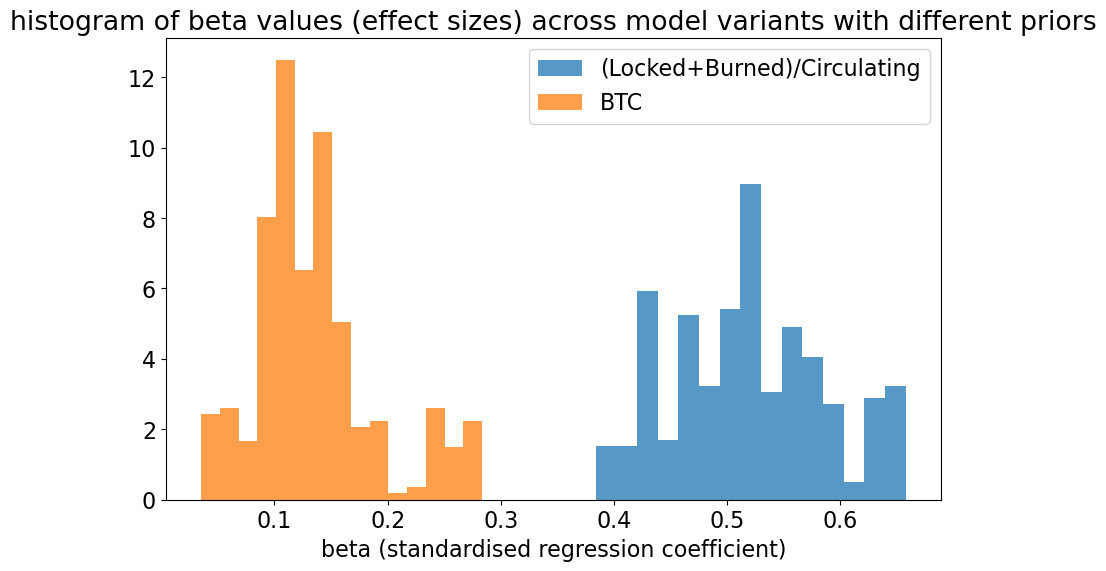

In [15]:
plt.hist(df_sensitivity['beta_btc_mean'].astype(float),density=True,bins=15,alpha=0.75,label="(Locked+Burned)/Circulating");
plt.hist(df_sensitivity['beta_(B+L)/CS_mean'].astype(float),density=True,bins=15,alpha=0.75,label="BTC");
plt.legend()
plt.title("histogram of beta values (effect sizes) across model variants with different priors")
plt.xlabel('beta (standardised regression coefficient)');

Interpretation: there _is_ some sensitivity to specification. 

In [16]:
SupplyRatio_mean=df_sensitivity['beta_(B+L)/CS_mean'].mean()
btc_mean = df_sensitivity['beta_btc_mean'].mean()
ratio = btc_mean / SupplyRatio_mean
pd.DataFrame({"SupplyRatio_beta_mean": [SupplyRatio_mean], "btc_beta_mean": [btc_mean], "Ratio": [ratio]})

,SupplyRatio_beta_mean,btc_beta_mean,Ratio
0,0.134891,0.518659,3.845019


But, on average, there is still is an effect for Supply Ratio. Roughly twice as small as for BTC.

### Shortfall
What happens if we use the Supply Ratio predictions post shortfall as our counterfactural covariate?

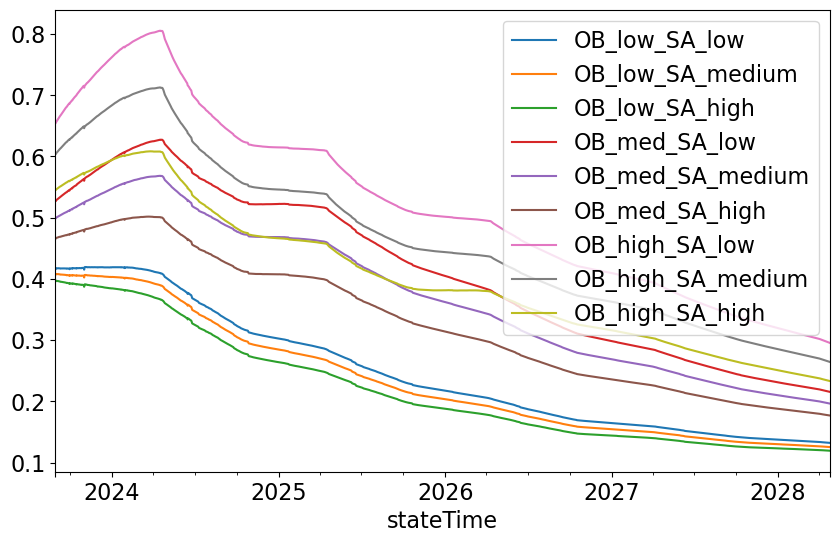

In [17]:
df0 = pd.read_csv('offline_info/locked_burnt_Repay.csv', parse_dates=[1])
df0.rename(columns={'date': 'stateTime'},inplace=True)
df0 = df0[df0['stateTime'] >= df.index[-1]] 
df0.reset_index(inplace = True)
df0.drop('index',axis=1, inplace=True)
df0.drop('Unnamed: 0',axis=1, inplace=True)
df0 = df0.set_index('stateTime').resample('D').interpolate(method='ffill')
df0.head()
df0.plot();

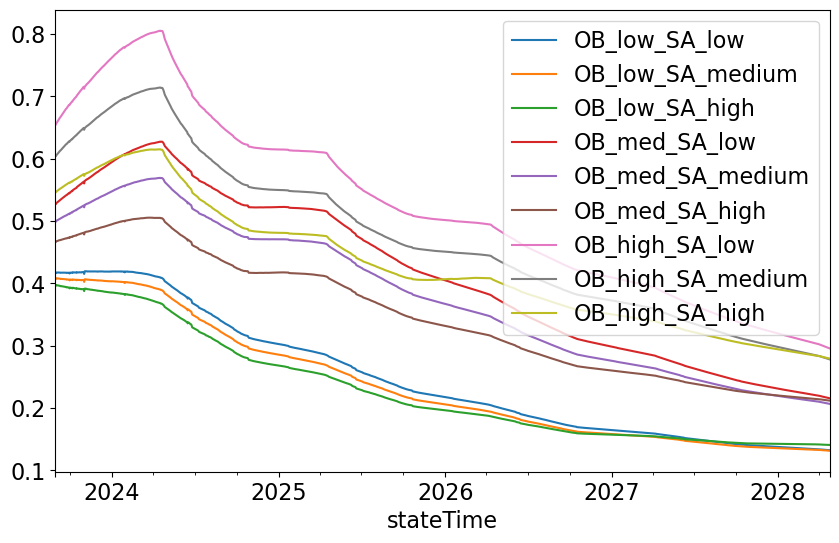

In [18]:
df1 = pd.read_csv('offline_info/locked_burnt_IF.csv', parse_dates=[1])
df1.rename(columns={'date': 'stateTime'},inplace=True)
df1 = df1[df1['stateTime'] >= df.index[-1]] 
df1.reset_index(inplace = True)
df1.drop('index',axis=1, inplace=True)
df1.drop('Unnamed: 0',axis=1, inplace=True)
df1 = df1.set_index('stateTime').resample('D').interpolate(method='ffill')
df1.head()
df1.plot();

In [19]:
# Define model to explain variation in FIL
# in terms of BTC, burned_plus_locked and random variation

X_ = price_df.index.values
y_ = price_df.FIL_std

def model_shortfall(y=None, 
          X=X_, 
          BTC=price_df['BTC_std'].values,
          burned_plus_locked=price_df['(B+L)/CS_std'].values,
          periodicity=14,
          n_forecast=None, 
          burned_plus_locked_counterfactual=None,
          y_sigma_scale=1,
          tau_scale=0.005,
          beta_btc_scale=0.1,
          beta_burned_plus_locked_scale=10,
         ):
    # likelihood scale prior
    y_sigma = numpyro.sample('y_sigma', dist.HalfNormal(scale=y_sigma_scale))
    # RW prior
    tau = numpyro.sample('tau', dist.HalfNormal(scale=tau_scale))
    # first coefficient of RW
    rw0 = numpyro.sample('rw0', dist.Normal(0,10))
    # btc coefficient prior
    beta_btc = numpyro.sample('beta_btc', dist.Normal(0,beta_btc_scale))
    # supply coefficient prior
    beta_burned_plus_locked = numpyro.sample('beta_(B+L)/CS', 
                                             dist.Normal(loc=0,scale=beta_burned_plus_locked_scale))
    # RW with periodicity day innovations
    nsteps = X.shape[0] // periodicity
    rw = numpyro.sample('rw_init', dist.GaussianRandomWalk(scale=tau, num_steps=nsteps))
    rw = numpyro.deterministic("rw", rw+rw0)
    rw = jnp.repeat(rw, periodicity)
    rw = jnp.append(rw, jnp.repeat(rw[-1], X.shape[0] % periodicity))
    mu = beta_btc * BTC + beta_burned_plus_locked * burned_plus_locked + rw
    
    # observational model
    numpyro.sample('obs', dist.Normal(loc=mu, scale=y_sigma), obs=y)
    
    # forecast future shortfall counterfactual for supply
    if n_forecast is not None:
        nsteps_f = n_forecast // periodicity
        rw_f = numpyro.sample('rw_init_f', dist.GaussianRandomWalk(scale=tau, num_steps=nsteps_f))
        rw_f = numpyro.deterministic("rw_f", rw_f + rw[-1])
        rw_f = jnp.repeat(rw_f, periodicity)
        rw_f = jnp.append(rw_f, jnp.repeat(rw_f[-1], n_forecast % periodicity))
        mu_f = beta_btc * jnp.repeat(BTC[-1], n_forecast) + beta_burned_plus_locked * burned_plus_locked_counterfactual+ rw_f
        numpyro.sample('y_pred', dist.Normal(loc=mu_f, scale=y_sigma), obs=None)

# fit model
INOVATION_RATE=30
NSTEPS=1000
mcmc = MCMC(
            NUTS(model_shortfall), 
            num_warmup=NSTEPS, num_samples=NSTEPS)
mcmc.run(random.PRNGKey(0), y=jnp.array(y_), 
         X=jnp.array(X_), 
         BTC=jnp.array(price_df['BTC_std'].values),
         burned_plus_locked=jnp.array(price_df['(B+L)/CS_std'].values), 
         periodicity=INOVATION_RATE)
samples = mcmc.get_samples()



sample: 100%|█| 2000/2000 [00:02<00:00, 836.41it/s, 47 steps of size 7.22e-02. a


**Policy = Repay**

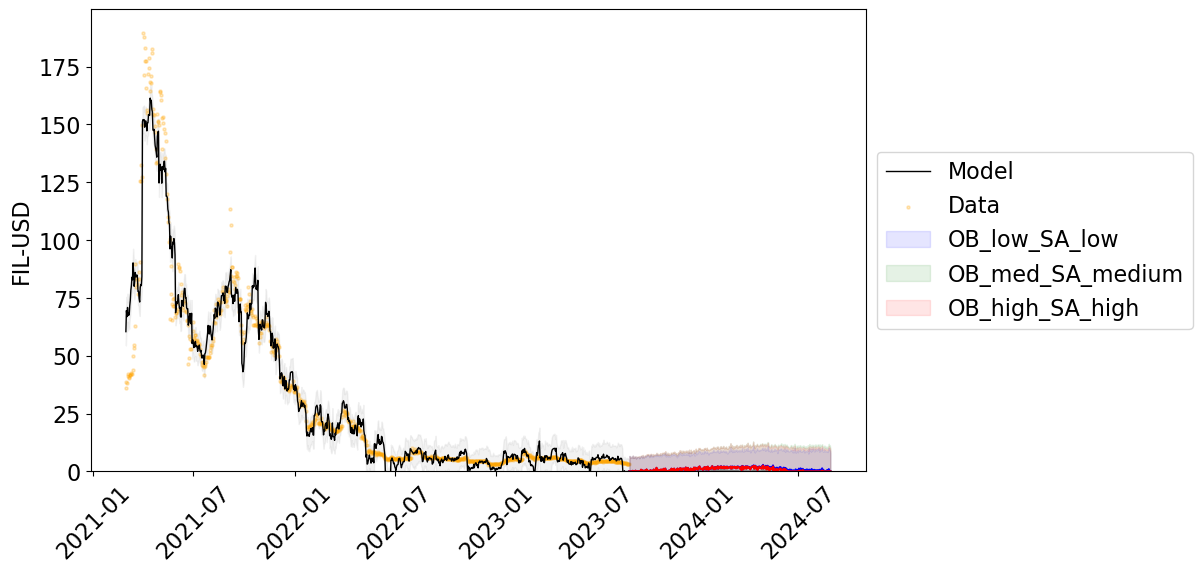

In [20]:
rng_key = random.PRNGKey(0)
predictive = Predictive(model_shortfall, samples)
predictions = predictive(rng_key,X=X_, BTC=jnp.array(price_df['BTC_std'].values),
         burned_plus_locked=jnp.array(price_df['(B+L)/CS_std'].values),  
                         periodicity=INOVATION_RATE)["obs"]
N_FORECAST = 365

df0_scaled = df0.pipe(lambda x: (x - (df0.iloc[1].values - price_df['(B+L)/CS'].values[-1]) - price_df[['(B+L)/CS']].mean().values[0])/price_df[['(B+L)/CS']].std().values[0])
def predict_scenario(scenario='OB_med_SA_medium', df_counter=df0_scaled):
    return predictive(rng_key, X=X_, BTC=jnp.array(price_df['BTC_std'].values),
                              burned_plus_locked=jnp.array(price_df['(B+L)/CS_std'].values),  
                              periodicity=INOVATION_RATE,
                              n_forecast=N_FORECAST,
                              burned_plus_locked_counterfactual=(df_counter[scenario].values[:N_FORECAST]))["y_pred"]
    
future_predictions_counter0_rs = np.maximum(rescale(predict_scenario(scenario='OB_low_SA_low', df_counter=df0_scaled)),0)
future_predictions_counter1_rs = np.maximum(rescale(predict_scenario(scenario='OB_med_SA_medium', df_counter=df0_scaled)),0)
future_predictions_counter2_rs = np.maximum(rescale(predict_scenario(scenario='OB_high_SA_high', df_counter=df0_scaled)),0)

dates_ = df.index
dates_pred_ = pd.date_range(start=df.index[-1]+timedelta(1), end=df.index[-1]+timedelta(N_FORECAST))
qu, ql = 0.75, 0.25
plt.plot(dates_, jnp.median(predictions_rs,axis=0),c='black',lw=1, label='Model')
plt.fill_between(dates_, jnp.quantile(predictions_rs, ql, axis=0),
                 jnp.quantile(predictions_rs,qu, axis=0), 
                 alpha=0.1, color='grey')
plt.scatter(df.index, price_df[['FIL']], alpha=0.25,c='orange',s=5, label='Data')
plt.plot(dates_pred_, jnp.median(future_predictions_counter0_rs, axis=0), 
         c='grey')

plt.fill_between(dates_pred_, jnp.quantile(future_predictions_counter0_rs, ql, axis=0),
                 jnp.quantile(future_predictions_counter0_rs,qu, axis=0), 
                 alpha=0.1, color='blue', label='OB_low_SA_low')
plt.plot(dates_pred_, jnp.median(future_predictions_counter1_rs, axis=0), 
         color='blue')
plt.fill_between(dates_pred_, jnp.quantile(future_predictions_counter1_rs,ql, axis=0),
                 jnp.quantile(future_predictions_counter1_rs,qu, axis=0),
                 alpha=0.1, color='green', label='OB_med_SA_medium')
plt.plot(dates_pred_, jnp.median(future_predictions_counter2_rs, axis=0), 
         color='red')
plt.fill_between(dates_pred_, jnp.quantile(future_predictions_counter2_rs,ql, axis=0),
                 jnp.quantile(future_predictions_counter2_rs,qu, axis=0),
                 alpha=0.1, color='red', label='OB_high_SA_high')

plt.ylim(0,)
plt.xticks(rotation=45)
plt.ylabel("FIL-USD")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [21]:
a = np.median(future_predictions_counter0_rs, axis=0)[-1]
b = np.median(future_predictions_counter1_rs, axis=0)[-1]
c = np.median(future_predictions_counter2_rs, axis=0)[-1]
d = np.round([np.quantile(future_predictions_counter0_rs,ql, axis=0)[-1] , np.quantile(future_predictions_counter0_rs,qu, axis=0)[-1]])
e = np.round([np.quantile(future_predictions_counter1_rs,ql, axis=0)[-1] , np.quantile(future_predictions_counter1_rs,qu, axis=0)[-1]])
f = np.round([np.quantile(future_predictions_counter2_rs,ql, axis=0)[-1], np.quantile(future_predictions_counter2_rs,qu, axis=0)[-1]])
shortfall_df_repay = pd.DataFrame({'Scenario' : ['OB_low_SA_low','OB_med_SA_medium','OB_high_SA_high'], 
              'FIL-USD median' : [a,b,c],
             'FIL-USD Q25-75' : [d,e,f]})
shortfall_df_repay = shortfall_df_repay.round()
shortfall_df_repay

,Scenario,FIL-USD median,FIL-USD Q25-75
0,OB_low_SA_low,0.0,"[0.0, 8.0]"
1,OB_med_SA_medium,0.0,"[0.0, 10.0]"
2,OB_high_SA_high,0.0,"[0.0, 9.0]"


**Policy = IF**

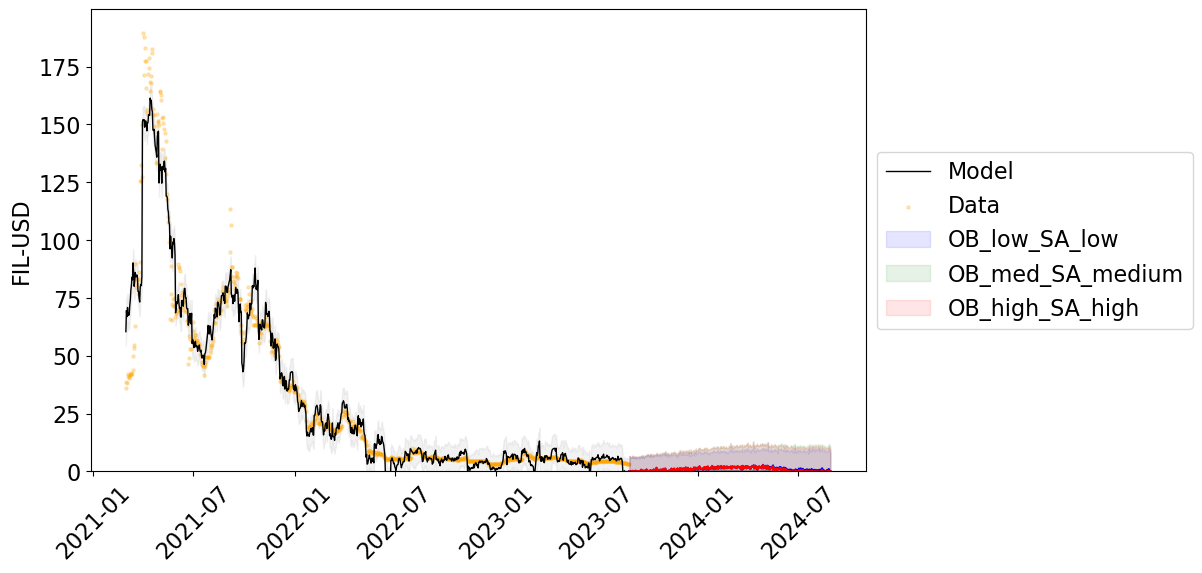

In [22]:
df1_scaled = df1.pipe(lambda x: (x - (df1.iloc[1].values - price_df['(B+L)/CS'].values[-1]) - price_df[['(B+L)/CS']].mean().values[0])/price_df[['(B+L)/CS']].std().values[0])
    
future_predictions_counter0_rs = np.maximum(rescale(predict_scenario(scenario='OB_low_SA_low', df_counter=df1_scaled)),0)
future_predictions_counter1_rs = np.maximum(rescale(predict_scenario(scenario='OB_med_SA_medium', df_counter=df1_scaled)),0)
future_predictions_counter2_rs = np.maximum(rescale(predict_scenario(scenario='OB_high_SA_high', df_counter=df1_scaled)),0)

dates_ = df.index
dates_pred_ = pd.date_range(start=df.index[-1]+timedelta(1), end=df.index[-1]+timedelta(N_FORECAST))
qu, ql = 0.75, 0.25
plt.plot(dates_, jnp.median(predictions_rs,axis=0),c='black',lw=1, label='Model')
plt.fill_between(dates_, jnp.quantile(predictions_rs, ql, axis=0),
                 jnp.quantile(predictions_rs,qu, axis=0), 
                 alpha=0.1, color='grey')
plt.scatter(df.index, price_df[['FIL']], alpha=0.25,c='orange',s=5, label='Data')
plt.plot(dates_pred_, jnp.median(future_predictions_counter0_rs, axis=0), 
         c='grey')

plt.fill_between(dates_pred_, jnp.quantile(future_predictions_counter0_rs, ql, axis=0),
                 jnp.quantile(future_predictions_counter0_rs,qu, axis=0), 
                 alpha=0.1, color='blue', label='OB_low_SA_low')
plt.plot(dates_pred_, jnp.median(future_predictions_counter1_rs, axis=0), 
         color='blue')
plt.fill_between(dates_pred_, jnp.quantile(future_predictions_counter1_rs,ql, axis=0),
                 jnp.quantile(future_predictions_counter1_rs,qu, axis=0),
                 alpha=0.1, color='green', label='OB_med_SA_medium')
plt.plot(dates_pred_, jnp.median(future_predictions_counter2_rs, axis=0), 
         color='red')
plt.fill_between(dates_pred_, jnp.quantile(future_predictions_counter2_rs,ql, axis=0),
                 jnp.quantile(future_predictions_counter2_rs,qu, axis=0),
                 alpha=0.1, color='red', label='OB_high_SA_high')

plt.ylim(0,)
plt.xticks(rotation=45)
plt.ylabel("FIL-USD")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [23]:
a = np.median(future_predictions_counter0_rs, axis=0)[-1]
b = np.median(future_predictions_counter1_rs, axis=0)[-1]
c = np.median(future_predictions_counter2_rs, axis=0)[-1]
d = np.round([np.quantile(future_predictions_counter0_rs,ql, axis=0)[-1] , np.quantile(future_predictions_counter0_rs,qu, axis=0)[-1]])
e = np.round([np.quantile(future_predictions_counter1_rs,ql, axis=0)[-1] , np.quantile(future_predictions_counter1_rs,qu, axis=0)[-1]])
f = np.round([np.quantile(future_predictions_counter2_rs,ql, axis=0)[-1], np.quantile(future_predictions_counter2_rs,qu, axis=0)[-1]])
shortfall_df_IF = pd.DataFrame({'Scenario' : ['OB_low_SA_low','OB_med_SA_medium','OB_high_SA_high'], 
              'FIL-USD median' : [a,b,c],
             'FIL-USD Q25-75' : [d,e,f]})
shortfall_df_IF.round()
shortfall_df_IF = shortfall_df_IF.round()

In [24]:
shortfall_df_IF

,Scenario,FIL-USD median,FIL-USD Q25-75
0,OB_low_SA_low,0.0,"[0.0, 8.0]"
1,OB_med_SA_medium,0.0,"[0.0, 10.0]"
2,OB_high_SA_high,0.0,"[0.0, 9.0]"


In [25]:
shortfall_df_repay

,Scenario,FIL-USD median,FIL-USD Q25-75
0,OB_low_SA_low,0.0,"[0.0, 8.0]"
1,OB_med_SA_medium,0.0,"[0.0, 10.0]"
2,OB_high_SA_high,0.0,"[0.0, 9.0]"
